In [1]:
import tensorflow as tf 
tf.enable_eager_execution()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [4]:
dataset = np.load('dsprites-dataset/dsprites_multiple_shapes_no_color.npz.npy')

In [5]:
def show_images_grid(imgs_, num_images=25):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

In [7]:
dataset = dataset.astype('float32')

In [8]:
TRAIN_BUF = 100000
BATCH_SIZE = 100

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(dataset[:100000]).shuffle(TRAIN_BUF).batch(BATCH_SIZE)

In [14]:
class VAEMultipleSprite(tf.keras.Model):
    """Same Architecture"""
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(64, 64, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=32, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=(2, 2), activation=tf.nn.elu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=2*2*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(2, 2, 64)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=(4, 4), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=(2, 2), padding="SAME", activation=tf.nn.elu),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=1, strides=(1, 1), padding="SAME"),
        ])
        
    def sample(self):
        latent = tf.random_normal(shape=(1, self.latent_dim))
        return latent, tf.nn.sigmoid(self.decoder(latent))
    
    def call(self, img, is_sigmoid=False):
        """Reuse the code from the Google Example"""
        mean, log_var = tf.split(self.encoder(img), num_or_size_splits=2, axis=1)
        
        normal = tf.random_normal(shape=mean.shape)
        latent = normal * tf.exp(log_var * .5) + mean
        
        out = self.decoder(latent)
        if is_sigmoid:
            out = tf.nn.sigmoid(out)
        return latent, out, mean, log_var

In [18]:
vae = VAEMultipleSprite(12)
optimizer = tf.train.AdamOptimizer(learning_rate=5e-5)

In [22]:
for e in range(4):
    print(f"At epoch {e}")
    for i, img in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            tape.watch(vae.variables)

            latent, out, mean, log_var = vae(img)
            
            # Reconstruction loss ? 
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=out, labels=img)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
            
            # KL Loss -- From https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/
            kl_loss = 0.5 * tf.reduce_sum(tf.exp(log_var) + mean**2 - 1. - log_var, axis=[1])
            
            loss = -tf.reduce_mean(logpx_z - kl_loss)
            if i % 100 == 0:
                print(loss)
                    
        grad = tape.gradient(loss, vae.variables)
        optimizer.apply_gradients(zip(grad, vae.variables))
    print(f"---------")

At epoch 0
tf.Tensor(219.4683, shape=(), dtype=float32)
tf.Tensor(203.00522, shape=(), dtype=float32)
tf.Tensor(216.32782, shape=(), dtype=float32)
tf.Tensor(199.96078, shape=(), dtype=float32)
tf.Tensor(210.20856, shape=(), dtype=float32)
tf.Tensor(217.58176, shape=(), dtype=float32)
tf.Tensor(217.45544, shape=(), dtype=float32)
tf.Tensor(208.7175, shape=(), dtype=float32)
tf.Tensor(197.17683, shape=(), dtype=float32)
tf.Tensor(204.6465, shape=(), dtype=float32)
---------
At epoch 1
tf.Tensor(208.58218, shape=(), dtype=float32)
tf.Tensor(201.23993, shape=(), dtype=float32)
tf.Tensor(193.9553, shape=(), dtype=float32)
tf.Tensor(205.75215, shape=(), dtype=float32)
tf.Tensor(198.66588, shape=(), dtype=float32)
tf.Tensor(200.02997, shape=(), dtype=float32)
tf.Tensor(208.95387, shape=(), dtype=float32)
tf.Tensor(191.68909, shape=(), dtype=float32)
tf.Tensor(193.2654, shape=(), dtype=float32)
tf.Tensor(201.62122, shape=(), dtype=float32)
---------
At epoch 2
tf.Tensor(209.46754, shape=(), d

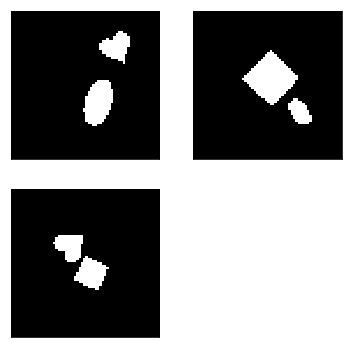

In [20]:
show_images_grid(tf.squeeze(img).numpy(), 3)

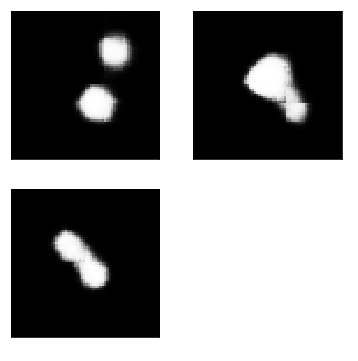

In [21]:
show_images_grid(tf.squeeze(tf.nn.sigmoid(out)).numpy(), 3)